In [130]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pycsou.operator.linop.diff as pydiff
import pycsou.operator.linop.filter as pyfilt
import pycsou.opt.solver as pysol
import pycsou.abc as pyca
import pycsou.opt.stop as pystop
import pycsou.operator.diffusion as pydiffusion
import pycsou.operator.linop.base as pycb
import forward_model.LoS_handling as LoS
import forward_model.reaction as pyreaction
import phantoms.phantoms as phantom
import forward_model.chord_geometry as geom
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import pycsou.abc.solver as pysolver
import pycsou.operator.func.norm as pynorm
import skimage as skim
import time
from IPython.display import display, clear_output
import matplotlib
import forward_model.tcv_forward_models as tomo_op
import scipy.io as scio
import scipy.sparse as scisp

In [2]:
%load_ext autoreload
%autoreload 2

# Load magnetic field information

Relevant for anisotropic smoothing along magnetic field lines.

Currently only `Bfield_phantom_field_aligned.npy` consistent with `phantom_field_aligned.npy` is available.
Soon also SOLPS phantom will have corresponding field.

Text(0.5, 1.0, '$\\Psi$ isolines')

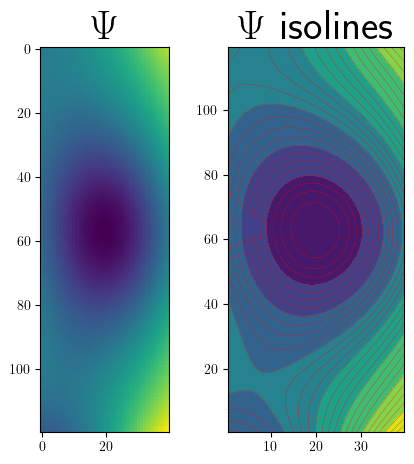

In [55]:
Bfield_phantom_field_aligned=np.load('phantoms/Bfield_saved/Bfield_phantom_field_aligned.npy')
fig, ax=plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(Bfield_phantom_field_aligned)
ax[0].set_title("$\Psi$", fontsize=30)
ax[1].contour(Bfield_phantom_field_aligned, origin="upper", levels=35, antialiased=True, colors="r", linewidths=0.2)
ax[1].contourf(Bfield_phantom_field_aligned, origin="upper")
ax[1].set_title("$\Psi$ isolines", fontsize=30)

# Load phantom models, or create new ones

Pre-computed phantoms stored in `tomo_fusion/phantoms/saved/`.

Gaussian, hollow, high-field-side and low-field-side phantoms can be created with  `tomo_fusion/phantoms/phantom.py` module.

**Remark** Standard 120x40 grid is typically used for now.


In [22]:
gaussian_phantom = np.load('phantoms/saved/gaussian_phantom.npy')
field_aligned_phantom = np.load('phantoms/saved/phantom_field_aligned.npy')
field_misaligned_phantom = np.load('phantoms/saved/phantom_field_misaligned.npy')
SOLPS_phantom = np.load('phantoms/saved/SOLPS_phantom.npy')

Text(0.5, 0.98, 'Pre-computed phantoms')

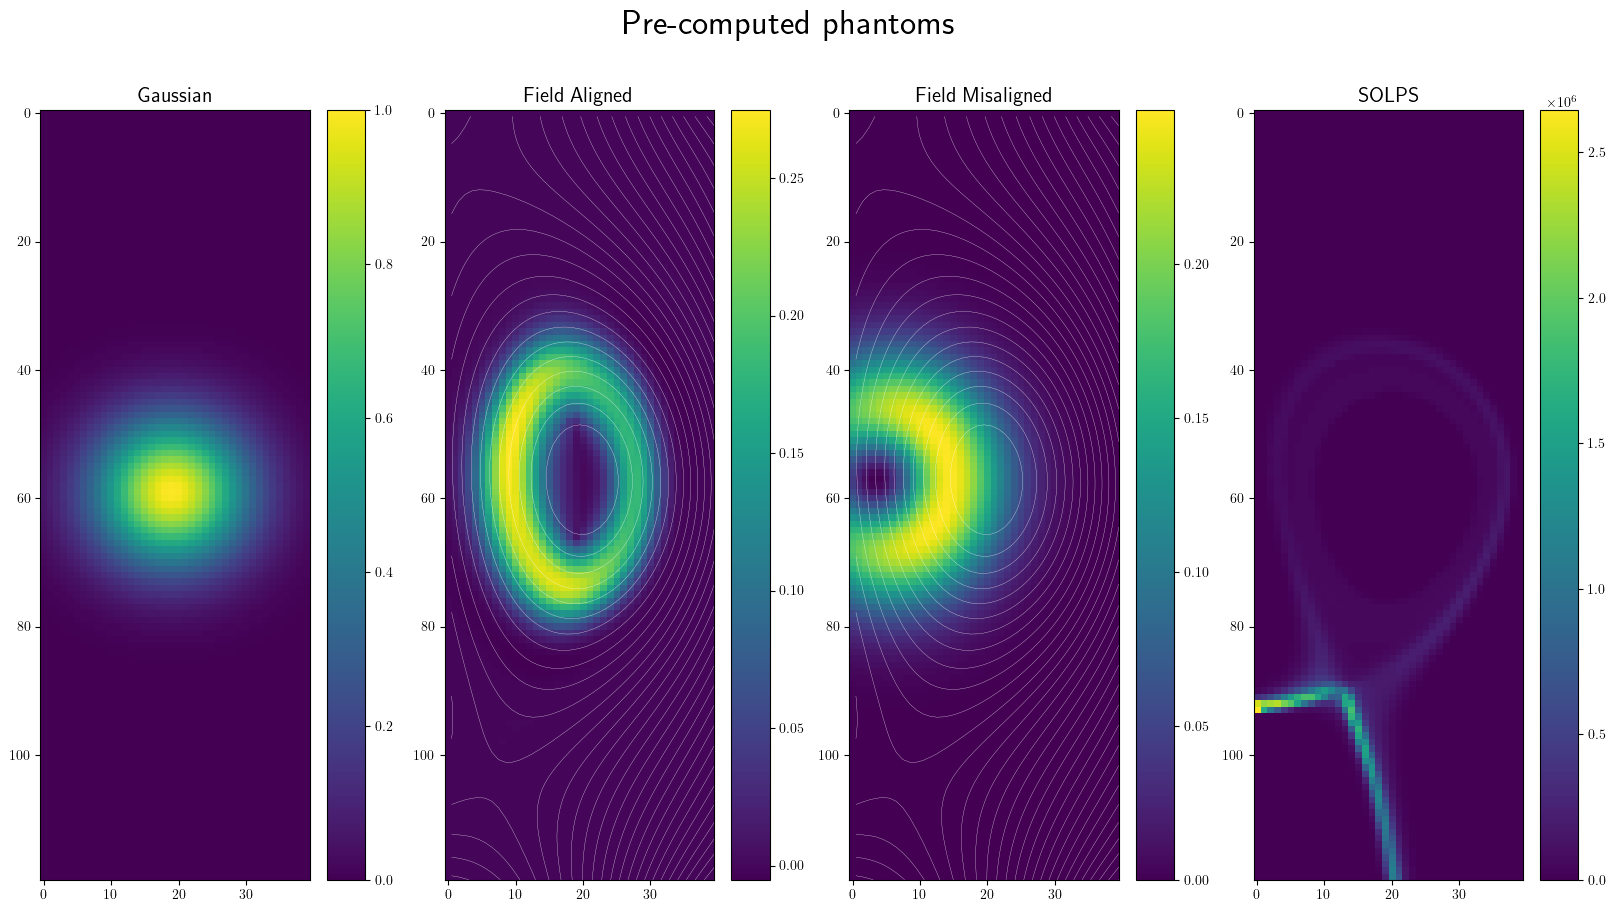

In [59]:
fig, ax = plt.subplots(1,4,figsize=(20,10))
p=ax[0].imshow(gaussian_phantom, aspect="auto")
plt.colorbar(p)
ax[0].set_title("Gaussian", fontsize=15)
p=ax[1].imshow(field_aligned_phantom, aspect="auto")
plt.colorbar(p)
ax[1].contour(Bfield_phantom_field_aligned, origin="lower", levels=35, antialiased=True, colors="w", linewidths=0.2)
ax[1].set_title("Field Aligned", fontsize=15)
p=ax[2].imshow(field_misaligned_phantom, aspect="auto")
plt.colorbar(p)
ax[2].contour(Bfield_phantom_field_aligned, origin="lower", levels=35, antialiased=True, colors="w", linewidths=0.2)
ax[2].set_title("Field Misaligned", fontsize=15)
p=ax[3].imshow(SOLPS_phantom, aspect="auto")
plt.colorbar(p)
ax[3].set_title("SOLPS", fontsize=15)
plt.suptitle("Pre-computed phantoms", fontsize = 25)

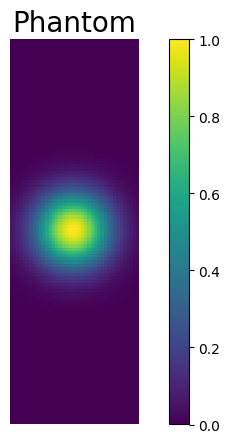

In [28]:
# Example of phantom creation
h=0.0125
Lr = 0.5
Lz = 1.5
zs = np.linspace(0, 1.5, round(Lz/h), endpoint=False)+0.5*h
rs = np.linspace(0, 0.5, round(Lr/h), endpoint=False)+0.5*h
R, Z = np.meshgrid(rs, zs)
phantom_image = phantom.generate_phantoms(R=R, Z=Z, phantom_type = 'gaussian', Rp = 0.5*h + h*19, Zp = 0.5*h + 59*h, rho2 = 0.1, aspect = 1)
plt.figure(figsize=(8,5))
p = plt.imshow(phantom_image)
plt.axis('off')
plt.title("Phantom", fontsize=20)
plt.colorbar()

# Forward Operator

Module `tomo_fusion/forward_model/tcv_forward_models.py` allows to initialize forward operators for TCV tomographic reconstruction.

Available **diagnostics** are "bolo", "axuv", "sxr", "artificial" (see doc and plot below).

Available **methods** are "lines", "spc_lines", "spc_beams".

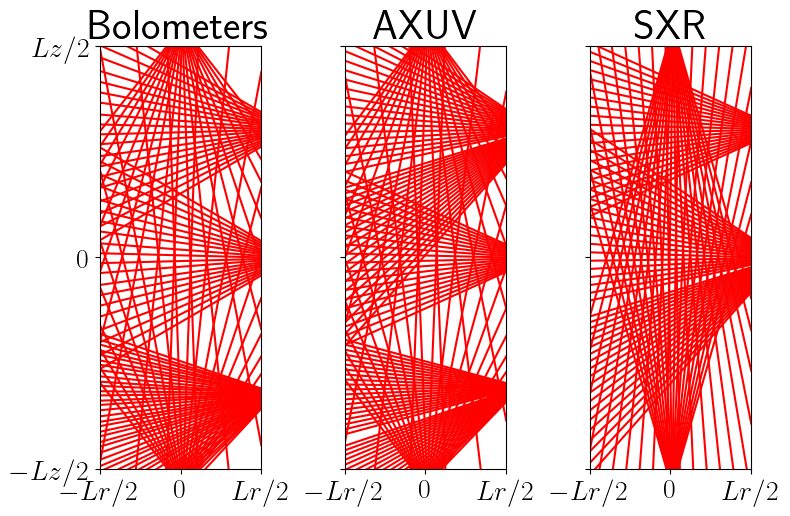

In [31]:
# Line of sight configurations
tomo_op.plot_diagnostics()

### Initializing the forward operator

RadonOpLines(120, 4800)

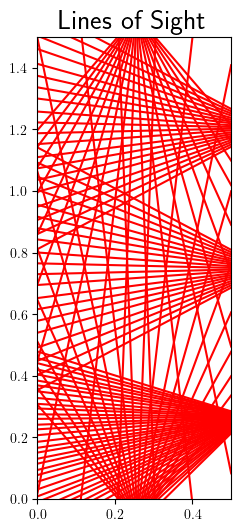

In [40]:
# bolometer diagnostic
ForwardOpBoloLines = tomo_op.SpcForwardModel(model="lines", diagnostic="bolo")
ForwardOpBoloLines

78th Line does not intersect domain!
79th Line does not intersect domain!
80th Line does not intersect domain!
81th Line does not intersect domain!
82th Line does not intersect domain!
83th Line does not intersect domain!
84th Line does not intersect domain!
85th Line does not intersect domain!
86th Line does not intersect domain!
87th Line does not intersect domain!
88th Line does not intersect domain!
89th Line does not intersect domain!
90th Line does not intersect domain!


RadonOpLines(156, 4800)

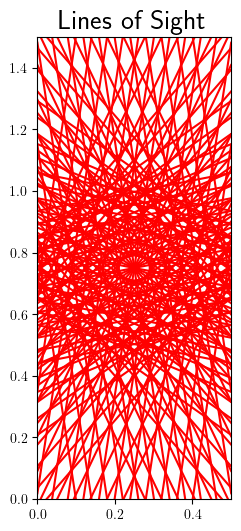

In [39]:
# artificial diagnostic with optimal coverage
ForwardOpArtificialLines = tomo_op.SpcForwardModel(model="lines", diagnostic="artificial")
ForwardOpArtificialLines

In [115]:
# line based SPC forward model
ForwardOpSpcLines = tomo_op.SpcForwardModel(model="spc_lines", diagnostic="bolo")
ForwardOpSpcLines

_ExplicitLinOp(119, 4800)

In [118]:
# beam based SPC forward model
ForwardOpSpcBeams = tomo_op.SpcForwardModel(model="spc_beams", diagnostic="bolo")
ForwardOpSpcBeams

_ExplicitLinOp(120, 4800)

### Apply Radon operator to phantom to simulate measured data (forward model)

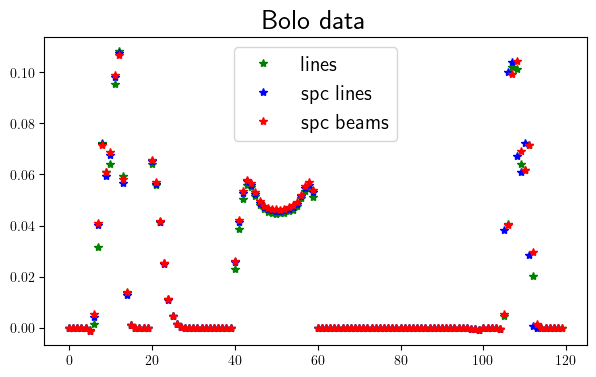

In [127]:
# Comparing forward models
data_lines_bolo = ForwardOpBoloLines.apply(field_aligned_phantom.reshape(1,-1)).flatten()
data_spc_lines_bolo = ForwardOpSpcLines.apply(field_aligned_phantom.reshape(1,-1)).flatten()
data_spc_beams_bolo = ForwardOpSpcBeams.apply(field_aligned_phantom.reshape(1,-1)).flatten()

plt.figure(figsize=(7,4))
plt.plot(data_lines_bolo.T, 'g*', label = "lines")
plt.plot(data_spc_lines_bolo.T, 'b*', label="spc lines")
plt.plot(data_spc_beams_bolo.T, 'r*', label="spc beams")
plt.title("Bolo data", fontsize=20)
plt.legend(fontsize=15)

## Corrupt by noise

Avoid negative values? To be discussed.

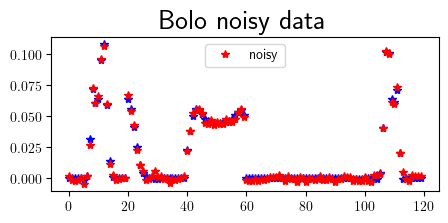

In [126]:
mean=np.mean(data_lines_bolo)
data_lines_bolo_noisy = data_lines_bolo.reshape(-1)+0.1*mean*np.random.randn(data_lines_bolo.size)

plt.figure(figsize=(5,2))
plt.plot(data_lines_bolo.T, 'b*')
plt.plot(data_lines_bolo_noisy, 'r*', label="noisy")
plt.title("Bolo noisy data", fontsize=20)
plt.legend()

## Define reaction operator
Corresponds to data-fidelity term.

In [175]:
# Create e.g. for ForwardOpBoloLines
ReactOpBolo = 0.5*pynorm.SquaredL2Norm(dim=ForwardOpBoloLines.codim).asloss(data_lines_bolo.flatten())*ForwardOpBoloLines

In [176]:
ReactOpBoloSpcLines = 0.5*pynorm.SquaredL2Norm(dim=ForwardOpSpcLines.codim).asloss(data_spc_lines_bolo.flatten())*ForwardOpSpcLines

# Define differential operators

In [140]:
grad = pydiff.Gradient(arg_shape=field_aligned_phantom.shape, diff_method="fd", scheme="forward",
                                         mode="reflect", sampling=h)

In [147]:
structure_tensor = pyfilt.StructureTensor(arg_shape=phantom_image.shape, mode="reflect",
                                          sampling=h, smooth_sigma=4, diff_method="gd", sigma=2*h)
# things changed for structure tensor?!

# Define Diffusion Operators (or other regularization operator)

Below, for example:
+ Tikhonov
+ Coherence enhancing with respect to magnetic field

In [149]:
# Define coherence-enhancing diffusion coefficient
# define diffusivity
Tikhonov_diffusivity = pydiffusion.TikhonovDiffusivity(arg_shape=field_aligned_phantom.shape)

# define diffusion coefficient
TikhonovDiffusionCoeff = pydiffusion.DiffusionCoeffIsotropic(arg_shape=field_aligned_phantom.shape, diffusivity=Tikhonov_diffusivity, trace_term=False)

# define divergence-based diffusion operator
DivergenceDiffusionOp = pydiffusion.DivergenceDiffusionOp(arg_shape=field_aligned_phantom.shape, gradient=grad,
                                                          diffusion_coefficient=TikhonovDiffusionCoeff)


In [148]:
# Define coherence-enhancing diffusion coefficient
DiffCoeffAnisCoherence = pydiffusion.DiffusionCoeffAnisoCoherenceEnhancing(arg_shape=field_aligned_phantom.shape,
                                                                           structure_tensor=structure_tensor,
                                                                           trace_term=False, alpha=0.01, m=1)

# define coherence-enhancing divergence based diffusion operator
DivergenceDiffusionOpCoherence = pydiffusion.DivergenceDiffusionOp(arg_shape=field_aligned_phantom.shape, gradient=grad,
                                                                   diffusion_coefficient=DiffCoeffAnisCoherence)

# freeze it to a value dictated by external field
DivergenceDiffusionOpCoherence.diffusion_coefficient.freeze(Bfield_phantom_field_aligned.reshape(1, -1))

/home/dhamm/Documents/pycsou_developer/pycsou/src/pycsou/operator/diffusion.py:2126: UserWarning: For anisotropic `diffusion_coefficient`, the estimated `diff_lipschitz` experimentally grants stability but is not guaranteed to hold.
  warnings.warn(msg)


# MAP computation

In [177]:
reg_param = 1e-5

f = ReactOpBolo + reg_param * DivergenceDiffusionOp
stop_crit = pystop.RelError(eps=1e-4, satisfy_all=False) | pystop.MaxIter(n=1000)

x0 = ForwardOpBoloLines.adjoint(data_lines_bolo_noisy).reshape(1,-1)

PGD = pysol.PGD(f = f, g = None, show_progress=True, verbosity=100)
PGD.fit(**dict(mode=pysolver.Mode.BLOCK, x0=x0, stop_crit=stop_crit, acceleration = False))

opt = PGD.solution()

INFO -- [2023-05-25 16:20:11.622611] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO -- [2023-05-25 16:20:17.596765] Iteration 100
	iteration: 100
	RelError[x]: 0.006656441091742831
	N_iter: 101.0
INFO -- [2023-05-25 16:20:21.071870] Iteration 200
	iteration: 200
	RelError[x]: 0.0025627224596750263
	N_iter: 201.0
INFO -- [2023-05-25 16:20:24.888634] Iteration 300
	iteration: 300
	RelError[x]: 0.0014175752525490935
	N_iter: 301.0
INFO -- [2023-05-25 16:20:28.225527] Iteration 400
	iteration: 400
	RelError[x]: 0.0009310605694998675
	N_iter: 401.0
INFO -- [2023-05-25 16:20:31.929564] Iteration 500
	iteration: 500
	RelError[x]: 0.0006741985304788736
	N_iter: 501.0
INFO -- [2023-05-25 16:20:35.272896] Iteration 600
	iteration: 600
	RelError[x]: 0.0005186619311908891
	N_iter: 601.0
INFO -- [2023-05-25 16:20:38.848097] Iteration 700
	iteration: 700
	RelError[x]: 0.0004153341243074462
	N_iter: 701.0
INFO -- [2023-05-25 16:20:42.363514] Iteration 800
	iteration: 800
	RelError[x]: 

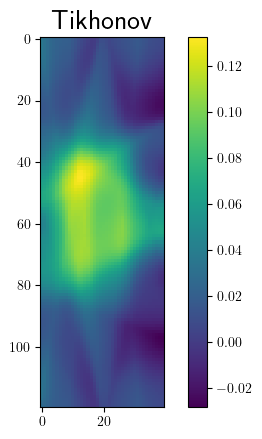

In [180]:
plt.imshow(opt.reshape(field_aligned_phantom.shape))
plt.title("Tikhonov", fontsize=20)
plt.colorbar()

In [184]:
reg_param = 5e-6

f = ReactOpBolo + reg_param * DivergenceDiffusionOpCoherence
stop_crit = pystop.RelError(eps=1e-4, satisfy_all=False) | pystop.MaxIter(n=2000)

x0 = ForwardOpBoloLines.adjoint(data_lines_bolo_noisy).reshape(1,-1)

PGD = pysol.PGD(f = f, g = None, show_progress=True, verbosity=100)
PGD.fit(**dict(mode=pysolver.Mode.BLOCK, x0=x0, stop_crit=stop_crit, acceleration = False))

opt = PGD.solution()

INFO -- [2023-05-25 16:23:56.812823] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO -- [2023-05-25 16:24:04.980386] Iteration 300
	iteration: 300
	RelError[x]: 0.0012373870676248122
	N_iter: 301.0
INFO -- [2023-05-25 16:24:11.143668] Iteration 100
	iteration: 100
	RelError[x]: 0.005596308429810143
	N_iter: 101.0
INFO -- [2023-05-25 16:24:16.278476] Iteration 400
	iteration: 400
	RelError[x]: 0.0008331755381065593
	N_iter: 401.0
INFO -- [2023-05-25 16:24:20.828722] Iteration 200
	iteration: 200
	RelError[x]: 0.002173779696430221
	N_iter: 201.0
INFO -- [2023-05-25 16:24:25.339784] Iteration 500
	iteration: 500
	RelError[x]: 0.0006222195948596887
	N_iter: 501.0
INFO -- [2023-05-25 16:24:30.051083] Iteration 300
	iteration: 300
	RelError[x]: 0.0012373870676248122
	N_iter: 301.0
INFO -- [2023-05-25 16:24:34.428286] Iteration 600
	iteration: 600
	RelError[x]: 0.0004986105843404708
	N_iter: 601.0
INFO -- [2023-05-25 16:24:38.855593] Iteration 400
	iteration: 400
	RelError[x]: 0

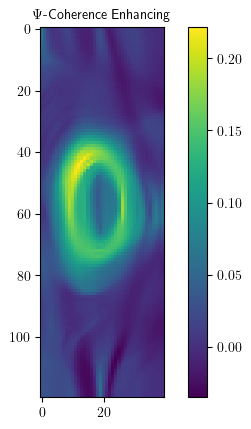

In [185]:
plt.imshow(opt.reshape(field_aligned_phantom.shape))
plt.title(r"$\Psi$-Coherence Enhancing", fontsize=10)
plt.colorbar()